In [1]:
from dataset import YouCookII
from dataset import YouCookIICollate
from torch.utils.data import DataLoader
from loss import loss_RA_MIL
from transformers import get_linear_schedule_with_warmup
from model import Model
from model_FC import ModelFC

import numpy as np
import torch
import matplotlib.pyplot as plt

def train(model, num_actions, batch_size, epochs=25, lr=0.001, y=0.5, MAX_DETECTIONS=20):
    dataset = YouCookII(num_actions, "/h/sagar/ece496-capstone/datasets/ycii")
    train_size = int(len(dataset) * (2/3))
    valid_size = int(len(dataset) - train_size)
    
    train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])
    
    collate = YouCookIICollate(MAX_DETECTIONS=MAX_DETECTIONS)
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(optimizer, int(0.2*epochs), epochs)

    train_loss = np.zeros(epochs)
    valid_loss = np.zeros(epochs)
    
    model.train()
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        num_batches = 0
        for data in train_dataloader:
            _, bboxes_tensor, features_tensor, steps_list, entity_list, entity_count_list, _, _ = data
            batch_size = len(data[0])
            
            # Zero out any gradients.
            optimizer.zero_grad()
            
            # Run inference (forward pass).
            scores, Y, B, M, VG_dist1, VG_dist2, VG_scores_index, RR_scores_index = model(batch_size, num_actions + 1, steps_list, features_tensor, bboxes_tensor, entity_count_list, entity_list)
            
            # Loss from alignment.
            loss_ = loss_RA_MIL(y=y, B=B, M=M, Y=Y, scores=scores, VG_dist1=VG_dist1, VG_dist2=VG_dist2)

            # Backpropagation (backward pass).
            loss_.backward()

            # Update parameters.
            optimizer.step()
            
            epoch_loss += loss_
            num_batches += 1
        
        # learning rate schedule
        # update after each epoch
        scheduler.step()
        epoch_loss = epoch_loss / num_batches
        
        # Save loss and accuracy at each epoch, plot (and checkpoint).
        train_loss[epoch] = epoch_loss
        valid_loss[epoch] = get_validation_loss(num_actions, y, valid_dataloader)
        
        # after epoch completes
        print("Epoch {} - Train Loss: {}, Validation Loss: {}".format(epoch + 1, train_loss[epoch], valid_loss[epoch]))
    
    plt.plot(train_loss, label='train loss')
    plt.plot(valid_loss, label='valid loss')
    plt.legend()
    plt.show()
        
    return train_loss, valid_loss

def get_validation_loss(num_actions, y, valid_dataloader):
    epoch_loss = 0.0
    num_batches = 0
        
    with torch.no_grad():
        for data in valid_dataloader:
            _, bboxes_tensor, features_tensor, steps_list, entity_list, entity_count_list, _, _ = data
            batch_size = len(data[0])

            # Run inference (forward pass).
            scores, Y, B, M, VG_dist1, VG_dist2, VG_scores_index, RR_scores_index = model(batch_size, num_actions + 1, steps_list, features_tensor, bboxes_tensor, entity_count_list, entity_list)

            # Loss from alignment.
            loss_ = loss_RA_MIL(y=y, B=B, M=M, Y=Y, scores=scores, VG_dist1=VG_dist1, VG_dist2=VG_dist2)
            
            epoch_loss += loss_
            num_batches += 1
            
    epoch_loss = epoch_loss / num_batches
    
    return epoch_loss

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model(device)

-17.582202911376953 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 664.5264892578125
-25.084796905517578 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 891.974365234375
-18.95791244506836 torch.Size([2, 8, 8, 2, 2])
Alignment Loss: 437.97393798828125
-14.217683792114258 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 498.3116455078125
-22.626644134521484 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 1041.052001953125
-16.010343551635742 torch.Size([2, 8, 8, 2, 2])
Alignment Loss: 294.21527099609375
-15.737926483154297 torch.Size([2, 8, 8, 2, 2])
Alignment Loss: 625.7940673828125
-24.745954513549805 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 544.5467529296875
-21.322595596313477 torch.Size([2, 8, 8, 5, 5])
Alignment Loss: 893.7178344726562
-19.735149383544922 torch.Size([2, 8, 8, 2, 2])
Alignment Loss: 442.296142578125
-16.70646858215332 torch.Size([2, 8, 8, 2, 2])
Alignment Loss: 290.3745422363281
-22.712615966796875 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 1007.4765625
-22.207000732421875 tor

-318.35260009765625 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 357.727294921875
-319.3514709472656 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 303.5086364746094
-321.5039978027344 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 352.1408996582031
-323.63037109375 torch.Size([2, 8, 8, 4, 4])
Alignment Loss: 420.19512939453125
-326.4868469238281 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 372.1458740234375
-328.2554016113281 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 393.6495666503906
-330.2831726074219 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 342.9632873535156
-330.1763000488281 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 151.01654052734375
-332.4878234863281 torch.Size([2, 8, 8, 4, 4])
Alignment Loss: 465.2623291015625
-330.35321044921875 torch.Size([2, 8, 8, 2, 2])
Alignment Loss: 223.0640869140625
-332.5558776855469 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 579.8749389648438
-331.0025939941406 torch.Size([2, 8, 8, 2, 2])
Alignment Loss: 250.18649291992188
-329.5328674316406 torch.S

-459.8792419433594 torch.Size([2, 8, 8, 2, 2])
Alignment Loss: 438.5863342285156
-463.527587890625 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 490.031005859375
-463.0696716308594 torch.Size([2, 8, 8, 4, 4])
Alignment Loss: 974.2197875976562
-460.5372314453125 torch.Size([2, 8, 8, 2, 2])
Alignment Loss: 355.984375
-463.61444091796875 torch.Size([2, 8, 8, 2, 2])
Alignment Loss: 375.060791015625
-461.9997863769531 torch.Size([1, 8, 8, 3, 3])
Alignment Loss: 418.52386474609375
Epoch 7 - Train Loss: 508.40625, Validation Loss: 530.2386474609375
-461.1103515625 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 404.12359619140625
-465.0113830566406 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 468.72430419921875
-465.5764465332031 torch.Size([2, 8, 8, 2, 2])
Alignment Loss: 359.43719482421875
-466.0273132324219 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 496.13134765625
-469.13897705078125 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 645.2123413085938
-473.01702880859375 torch.Size([2, 8, 8, 2, 2])
Al

-597.7854614257812 torch.Size([2, 8, 8, 2, 2])
Alignment Loss: 608.2590942382812
-602.5886840820312 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 302.85321044921875
-602.461669921875 torch.Size([2, 8, 8, 5, 5])
Alignment Loss: 619.95556640625
-604.7774658203125 torch.Size([2, 8, 8, 2, 2])
Alignment Loss: 302.832275390625
-606.3026123046875 torch.Size([2, 8, 8, 2, 2])
Alignment Loss: 261.84521484375
-606.8011474609375 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 769.2617797851562
-610.9583740234375 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 914.9345092773438
-611.9979248046875 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 796.9930419921875
-615.9906616210938 torch.Size([2, 8, 8, 4, 4])
Alignment Loss: 943.5308837890625
-619.2223510742188 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 686.1173706054688
-620.3556518554688 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 684.8433837890625
-623.6351928710938 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 631.1825561523438
-627.605712890625 torch.Size([2, 

-732.8136596679688 torch.Size([2, 8, 8, 4, 4])
Alignment Loss: 970.7098388671875
-732.35107421875 torch.Size([2, 8, 8, 2, 2])
Alignment Loss: 336.44671630859375
-732.8939208984375 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 752.837158203125
-733.35498046875 torch.Size([2, 8, 8, 2, 2])
Alignment Loss: 499.76690673828125
-731.0689697265625 torch.Size([2, 8, 8, 2, 2])
Alignment Loss: 431.39459228515625
-734.2174072265625 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 565.06591796875
-734.3954467773438 torch.Size([2, 8, 8, 4, 4])
Alignment Loss: 1134.8314208984375
-732.2023315429688 torch.Size([2, 8, 8, 2, 2])
Alignment Loss: 407.16485595703125
-732.9398193359375 torch.Size([2, 8, 8, 2, 2])
Alignment Loss: 618.4335327148438
-730.1063842773438 torch.Size([1, 8, 8, 3, 3])
Alignment Loss: 343.8223876953125
Epoch 14 - Train Loss: 598.6893310546875, Validation Loss: 606.0473022460938
-732.0258178710938 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 724.8807373046875
-735.6041259765625 torch.Size([2, 

-828.3389282226562 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 315.794921875
-830.0890502929688 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 354.59521484375
-832.3217163085938 torch.Size([2, 8, 8, 2, 2])
Alignment Loss: 189.58013916015625
-834.2144165039062 torch.Size([2, 8, 8, 2, 2])
Alignment Loss: 360.91888427734375
-836.6494140625 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 304.102783203125
-835.70849609375 torch.Size([2, 8, 8, 5, 5])
Alignment Loss: 486.6025390625
-837.9795532226562 torch.Size([2, 8, 8, 2, 2])
Alignment Loss: 489.2420654296875
-839.1734008789062 torch.Size([2, 8, 8, 2, 2])
Alignment Loss: 170.47442626953125
-838.0629272460938 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 458.294921875
-841.6290893554688 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 456.9027099609375
-844.5007934570312 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 268.0933837890625
-846.6079711914062 torch.Size([2, 8, 8, 4, 4])
Alignment Loss: 271.740234375
-847.4806518554688 torch.Size([2, 8, 8, 3, 3])
A

-924.9257202148438 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 181.255859375
-925.5360717773438 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 184.79248046875
-926.744384765625 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 154.07275390625
-927.6500854492188 torch.Size([2, 8, 8, 4, 4])
Alignment Loss: 214.2427978515625
-927.5820922851562 torch.Size([2, 8, 8, 2, 2])
Alignment Loss: 66.28076171875
-927.6615600585938 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 152.1480712890625
-927.208740234375 torch.Size([2, 8, 8, 2, 2])
Alignment Loss: 107.4381103515625
-927.2826538085938 torch.Size([2, 8, 8, 2, 2])
Alignment Loss: 143.56982421875
-927.7109985351562 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 153.11328125
-927.8834838867188 torch.Size([2, 8, 8, 4, 4])
Alignment Loss: 247.5950927734375
-927.497802734375 torch.Size([2, 8, 8, 2, 2])
Alignment Loss: 103.337646484375
-927.5031127929688 torch.Size([2, 8, 8, 2, 2])
Alignment Loss: 119.504638671875
-927.544677734375 torch.Size([1, 8, 8, 3, 3])
Align

-961.2146606445312 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 89.9833984375
-961.339111328125 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 81.6998291015625
-961.7025756835938 torch.Size([2, 8, 8, 2, 2])
Alignment Loss: 64.44805908203125
-961.7191772460938 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 164.9814453125
-961.9014892578125 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 105.76171875
-961.845458984375 torch.Size([2, 8, 8, 2, 2])
Alignment Loss: 63.7415771484375
-962.4002075195312 torch.Size([2, 8, 8, 2, 2])
Alignment Loss: 69.94580078125
-962.6203002929688 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 30.590087890625
-962.8501586914062 torch.Size([2, 8, 8, 5, 5])
Alignment Loss: 112.644775390625
-962.8660278320312 torch.Size([2, 8, 8, 2, 2])
Alignment Loss: 47.47613525390625
-963.1646728515625 torch.Size([2, 8, 8, 2, 2])
Alignment Loss: 41.67034912109375
-963.4286499023438 torch.Size([2, 8, 8, 3, 3])
Alignment Loss: 106.078857421875
-963.5813598632812 torch.Size([2, 8, 8, 3, 3])
Alig

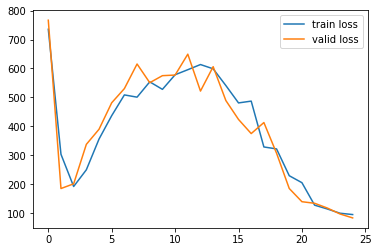

In [4]:
# Trainer.

train_loss, valid_loss = train(model, 8, 2, epochs=25, lr=1e-3)

In [5]:
# Evaluation.

from eval_fi import eval_all_dataset
eval_all_dataset(model)

-966.4428100585938 torch.Size([1, 10, 10, 7, 7])
--------------------------------------------------
Action 1: in a bowl, add ground beef, salt, pepper, 1 egg, dijon mustard and bread crumbs
Best IoU possible = 0.8062977194786072
Random Candidate IoU = 0.22095251083374023
Chosen Frame IoU: 0.05940777808427811
Best IoU possible = 0.617510199546814
Random Candidate IoU = 0.3780594766139984
Chosen Frame IoU: 0.025058064609766006
This entity has no ground truth bounding box
This entity has no ground truth bounding box
This entity has no ground truth bounding box
This entity has no ground truth bounding box
This entity has no ground truth bounding box
--------------------------------------------------
Action 2: mix the ingredients with hand
Best IoU possible = 0.5895182490348816
Random Candidate IoU = 0.2873440086841583
Chosen Frame IoU: 0.2767072021961212
This entity has no ground truth bounding box
--------------------------------------------------
Action 3: Add vegetable oil in a pan
Best

-966.4359741210938 torch.Size([1, 10, 10, 2, 2])
--------------------------------------------------
Action 1: cut the cabbage into small pieces
Best IoU possible = 0.8641247749328613
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
This entity has no ground truth bounding box
--------------------------------------------------
Action 2: Add carawat seeds, sea salt
Best IoU possible = 0.11877390742301941
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
This entity has no ground truth bounding box
--------------------------------------------------
Action 3: mix them evenly in the cabbage
Best IoU possible = 0.22755128145217896
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
Best IoU possible = 0.8508214950561523
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
--------------------------------------------------
Action 4: Add some leftover brine in a jar
Best IoU possible = 0.23314441740512848
Random Candidate IoU = 0.16639719903469086
Chosen Frame IoU: 0.0
Best IoU possible = 0.2371810972

Best IoU possible = 0.06644225120544434
Random Candidate IoU = 0.051163818687200546
Chosen Frame IoU: 0.0
This entity has no ground truth bounding box
--------------------------------------------------
Action 8: place the meat in a pan
Best IoU possible = 0.6534976959228516
Random Candidate IoU = 0.0253975261002779
Chosen Frame IoU: 0.0
Best IoU possible = 0.7325146198272705
Random Candidate IoU = 0.2055184543132782
Chosen Frame IoU: 0.0
--------------------------------------------------
Action 9: Pour the marinade over the ribs
Best IoU possible = 0.5089059472084045
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
Best IoU possible = 0.49866431951522827
Random Candidate IoU = 0.05570187339146828
Chosen Frame IoU: 0.0
Mean Upper Bound IoU: 0.47894033789634705, Mean Random IoU: 0.05203605443239212, Mean Model IoU: 0.055538859218358994
Top-1 acc@0.5:
Proposal Upper Bound: 0.5333333333333333, Random: 0.0, Model: 0.06666666666666667
-966.4447021484375 torch.Size([1, 11, 11, 4, 4])
--------

Best IoU possible = 0.5170888304710388
Random Candidate IoU = 0.4344768524169922
Chosen Frame IoU: 0.02001098357141018
--------------------------------------------------
Action 6: Flip the bread
Best IoU possible = 0.8848225474357605
Random Candidate IoU = 0.44299742579460144
Chosen Frame IoU: 0.0
--------------------------------------------------
Action 7: spread some sauce
Best IoU possible = 0.30627989768981934
Random Candidate IoU = 0.2249946559300308
Chosen Frame IoU: 0.0
--------------------------------------------------
Action 8: add ham, shredded cheese and more sauce and ham
Best IoU possible = 0.6280260682106018
Random Candidate IoU = 0.15837913751602173
Chosen Frame IoU: 0.07973373681306839
Best IoU possible = 0.6028886437416077
Random Candidate IoU = 0.39379602670669556
Chosen Frame IoU: 0.030249809846282005
This entity has no ground truth bounding box
This entity has no ground truth bounding box
--------------------------------------------------
Action 9: Cover it with ano

-966.4483032226562 torch.Size([1, 12, 12, 4, 4])
--------------------------------------------------
Action 1: Cook pancetta in a pan with oil
Best IoU possible = 0.6409754157066345
Random Candidate IoU = 0.33501505851745605
Chosen Frame IoU: 0.0
Best IoU possible = 0.7486287355422974
Random Candidate IoU = 0.01715623401105404
Chosen Frame IoU: 0.021473268046975136
--------------------------------------------------
Action 2: Melt butter in a pan
Best IoU possible = 0.1002126033087652
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
Best IoU possible = 0.6172184944152832
Random Candidate IoU = 0.5749757885932922
Chosen Frame IoU: 0.08536478132009506
--------------------------------------------------
Action 3: mix the flour with the butter
Best IoU possible = 0.5315556078534311
Random Candidate IoU = 0.06183241307735443
Chosen Frame IoU: 0.0
Best IoU possible = 0.5926930904388428
Random Candidate IoU = 0.3454553186893463
Chosen Frame IoU: 0.0
----------------------------------------------

Best IoU possible = 0.7263505458831787
Random Candidate IoU = 0.14625093340873718
Chosen Frame IoU: 0.0
This entity has no ground truth bounding box
This entity has no ground truth bounding box
--------------------------------------------------
Action 6: cut the green onion into large pieces
Best IoU possible = 0.28653979301452637
Random Candidate IoU = 0.04601777489026286
Chosen Frame IoU: 0.0
This entity has no ground truth bounding box
--------------------------------------------------
Action 7: add to the pan
Best IoU possible = 0.283769428730011
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
--------------------------------------------------
Action 8: Add the sauce and udon noodles to the pan
Best IoU possible = 0.23679941540144323
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
Best IoU possible = 0.7446697991398067
Random Candidate IoU = 0.35439532995224
Chosen Frame IoU: 0.0
This entity has no ground truth bounding box
--------------------------------------------------
Actio

-966.4478149414062 torch.Size([1, 13, 13, 5, 5])
--------------------------------------------------
Action 1: Add the meat to a bowl
Best IoU possible = 0.6369763016700745
Random Candidate IoU = 0.2713867127895355
Chosen Frame IoU: 0.0
Best IoU possible = 0.7751123309135437
Random Candidate IoU = 0.4328289330005646
Chosen Frame IoU: 0.05887386575341225
--------------------------------------------------
Action 2: Add garlic salt, sugar, sesame oil, and sauce to the meat
Best IoU possible = 0.579009473323822
Random Candidate IoU = 0.20533962547779083
Chosen Frame IoU: 0.0
Best IoU possible = 0.6803960800170898
Random Candidate IoU = 0.24577443301677704
Chosen Frame IoU: 0.0
This entity has no ground truth bounding box
This entity has no ground truth bounding box
This entity has no ground truth bounding box
--------------------------------------------------
Action 3: Add cabbage, green onion, and carrots to the bowl
Best IoU possible = 0.9114023945345754
Random Candidate IoU = 0.454007297

Best IoU possible = 0.6563902497291565
Random Candidate IoU = 0.21304607391357422
Chosen Frame IoU: 0.051017362624406815
--------------------------------------------------
Action 7: Add a tbsp of all purpose flour
Best IoU possible = 0.7070802450180054
Random Candidate IoU = 0.559222400188446
Chosen Frame IoU: 0.0634443461894989
--------------------------------------------------
Action 8: add the onion rings into it
Best IoU possible = 0.8675620555877686
Random Candidate IoU = 0.14220936596393585
Chosen Frame IoU: 0.0
Best IoU possible = 0.7328176498413086
Random Candidate IoU = 0.5773057341575623
Chosen Frame IoU: 0.04896417632699013
--------------------------------------------------
Action 9: shake it well to coat
Best IoU possible = 0.7388615012168884
Random Candidate IoU = 0.5984671711921692
Chosen Frame IoU: 0.04750703275203705
This entity has no ground truth bounding box
--------------------------------------------------
Action 10: Dip the onion rings into the batter
Best IoU pos

Best IoU possible = 0.436037707193426
Random Candidate IoU = 0.09606542438268661
Chosen Frame IoU: 0.0
Best IoU possible = 0.6022859194153712
Random Candidate IoU = 0.114350326359272
Chosen Frame IoU: 0.0
--------------------------------------------------
Action 11: melt the mozzarella by putting the chicken in the oven for 5 mins
Best IoU possible = 0.4333764051468516
Random Candidate IoU = 0.14857736229896545
Chosen Frame IoU: 0.0
--------------------------------------------------
Action 12: Cook some pasta in the pan
Best IoU possible = 0.198995441198349
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
Best IoU possible = 0.6367907524108887
Random Candidate IoU = 0.01251793373376131
Chosen Frame IoU: 0.0
--------------------------------------------------
Action 13: mix it with the sauce and pecorino cheese
Best IoU possible = 0.6135243773460388
Random Candidate IoU = 0.1253669559955597
Chosen Frame IoU: 0.0
Best IoU possible = 0.45271849933483943
Random Candidate IoU = 0.22151044011

-966.44384765625 torch.Size([1, 15, 15, 2, 2])
--------------------------------------------------
Action 1: cut through the core of the cabbage into half
Best IoU possible = 0.8377902507781982
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
This entity has no ground truth bounding box
--------------------------------------------------
Action 2: remove the tough core
Best IoU possible = 0.2688540816307068
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
--------------------------------------------------
Action 3: dice the cabbage
Best IoU possible = 0.8618393233165826
Random Candidate IoU = 0.027491837425582945
Chosen Frame IoU: 0.0
--------------------------------------------------
Action 4: Put the cabbage into a pan
Best IoU possible = 0.1904536932706833
Random Candidate IoU = 0.030422566458582878
Chosen Frame IoU: 0.0
Best IoU possible = 0.8514590859413147
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
--------------------------------------------------
Action 5: add diced potatoe

Best IoU possible = 0.8408356308937073
Random Candidate IoU = 0.11423900723457336
Chosen Frame IoU: 0.0
This entity has no ground truth bounding box
This entity has no ground truth bounding box
--------------------------------------------------
Action 6: Add flour
Best IoU possible = 0.7922376990318298
Random Candidate IoU = 0.36183735728263855
Chosen Frame IoU: 0.001468211063183844
--------------------------------------------------
Action 7: mix it up
Best IoU possible = 0.8677593469619751
Random Candidate IoU = 0.28412938117980957
Chosen Frame IoU: 0.000737387512344867
--------------------------------------------------
Action 8: Fry the marinated chicken in a frying pan
Best IoU possible = 0.5481219291687012
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
Best IoU possible = 0.6326996684074402
Random Candidate IoU = 0.21724916994571686
Chosen Frame IoU: 0.01857243850827217
--------------------------------------------------
Action 9: mix sesame oil, red chili in a pan
Best IoU possib

Best IoU possible = 0.5793358087539673
Random Candidate IoU = 0.5793358087539673
Chosen Frame IoU: 0.1920376867055893
--------------------------------------------------
Action 8: mix
No entities detected for this action.
--------------------------------------------------
Action 9: place rounds of canadian bacon onto a hot skillet
Best IoU possible = 0.6723319292068481
Random Candidate IoU = 0.3211386501789093
Chosen Frame IoU: 0.2055712789297104
Best IoU possible = 0.5179982781410217
Random Candidate IoU = 0.37911754846572876
Chosen Frame IoU: 0.17894697189331055
--------------------------------------------------
Action 10: Add distilled vinegar to a pan of hot water
Best IoU possible = 0.8786023855209351
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
Best IoU possible = 0.5465701222419739
Random Candidate IoU = 0.1937205046415329
Chosen Frame IoU: 0.13078604638576508
--------------------------------------------------
Action 11: add eggs
Best IoU possible = 0.44652411341667175
Random

Best IoU possible = 0.6975743770599365
Random Candidate IoU = 0.3107316195964813
Chosen Frame IoU: 0.0
This entity has no ground truth bounding box
--------------------------------------------------
Action 6: stir
No entities detected for this action.
--------------------------------------------------
Action 7: Add the vegetables to the wok
Best IoU possible = 0.7915940880775452
Random Candidate IoU = 0.7915940880775452
Chosen Frame IoU: 0.0
Best IoU possible = 0.833109064461089
Random Candidate IoU = 0.07527723908424377
Chosen Frame IoU: 0.0
--------------------------------------------------
Action 8: stir
No entities detected for this action.
--------------------------------------------------
Action 9: mix flour and water together
Best IoU possible = 0.20982539494764632
Random Candidate IoU = 0.022409390658140182
Chosen Frame IoU: 0.0
This entity has no ground truth bounding box
--------------------------------------------------
Action 10: heat the paste in the microwave
Best IoU pos

Best IoU possible = 0.6112242341041565
Random Candidate IoU = 0.48354239818338557
Chosen Frame IoU: 0.0050829206593334675
--------------------------------------------------
Action 9: place the pizza crust on it
Best IoU possible = 0.29943621437369516
Random Candidate IoU = 0.1598128378391266
Chosen Frame IoU: 0.0
Best IoU possible = 0.6045343279838562
Random Candidate IoU = 0.1754353642463684
Chosen Frame IoU: 0.005254593677818775
--------------------------------------------------
Action 10: Spread a layer of pizza sauce
Best IoU possible = 0.49806561342578604
Random Candidate IoU = 0.4362063407897949
Chosen Frame IoU: 0.0
--------------------------------------------------
Action 11: add a layer of grated cheese
Best IoU possible = 0.6694362528398811
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
--------------------------------------------------
Action 12: place the sliced pepperoni
Best IoU possible = 0.504597657449338
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
--------------

Chosen Frame IoU: 0.0
--------------------------------------------------
Action 12: Drain the pasta
Best IoU possible = 0.5250295400619507
Random Candidate IoU = 0.034597624093294144
Chosen Frame IoU: 0.034597624093294144
--------------------------------------------------
Action 13: add to the prosciutto
Best IoU possible = 0.5918805003166199
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.028878336772322655
--------------------------------------------------
Action 14: add a little water
This entity has no ground truth bounding box
--------------------------------------------------
Action 15: Take everything in the pan out in a bowl
Best IoU possible = 0.6834644675254822
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
Best IoU possible = 0.8080721497535706
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
--------------------------------------------------
Action 16: pour in the sauce
Best IoU possible = 0.5893232822418213
Random Candidate IoU = 0.3092625141143799
Chosen Frame IoU: 0.0
-

Best IoU possible = 0.8488767147064209
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
--------------------------------------------------
Action 13: Add oil to the pan
Best IoU possible = 0.603287031376755
Random Candidate IoU = 0.11063928157091141
Chosen Frame IoU: 0.0
Best IoU possible = 0.5431925654411316
Random Candidate IoU = 0.21421974897384644
Chosen Frame IoU: 0.06347049027681351
--------------------------------------------------
Action 14: add the noodles
Best IoU possible = 0.7735040187835693
Random Candidate IoU = 0.13018938899040222
Chosen Frame IoU: 0.0
--------------------------------------------------
Action 15: Add the stir fry sauce to the pan
This entity has no ground truth bounding box
Best IoU possible = 0.5285894870758057
Random Candidate IoU = 0.19469384849071503
Chosen Frame IoU: 0.0685468316078186
--------------------------------------------------
Action 16: Add the vegetables and pork to the noodles
Best IoU possible = 0.6627501845359802
Random Candidate IoU =

Best IoU possible = 0.8621889352798462
Random Candidate IoU = 0.2011711746454239
Chosen Frame IoU: 0.0
Best IoU possible = 0.5158435106277466
Random Candidate IoU = 0.35931044816970825
Chosen Frame IoU: 0.013961347751319408
--------------------------------------------------
Action 11: Add onions, garlic
Best IoU possible = 0.8975192904472351
Random Candidate IoU = 0.49830591678619385
Chosen Frame IoU: 0.0
Best IoU possible = 0.67768394947052
Random Candidate IoU = 0.20354004204273224
Chosen Frame IoU: 0.0
--------------------------------------------------
Action 12: saute
No entities detected for this action.
--------------------------------------------------
Action 13: Add favourite pasta sauce, a little water
Best IoU possible = 0.6611232757568359
Random Candidate IoU = 0.2292078137397766
Chosen Frame IoU: 0.28003671765327454
Best IoU possible = 0.6388763189315796
Random Candidate IoU = 0.2214949131011963
Chosen Frame IoU: 0.270613431930542
-------------------------------------------

-966.4468383789062 torch.Size([1, 23, 23, 4, 4])
--------------------------------------------------
Action 1: peel a onion
Best IoU possible = 0.6864221692085266
Random Candidate IoU = 0.42329666018486023
Chosen Frame IoU: 0.0
--------------------------------------------------
Action 2: chop it into pieces
Best IoU possible = 0.7716975212097168
Random Candidate IoU = 0.3500441908836365
Chosen Frame IoU: 0.03804023936390877
This entity has no ground truth bounding box
--------------------------------------------------
Action 3: heat the onion in a pot with olive oil in it
Best IoU possible = 0.7150817792313797
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
Best IoU possible = 0.5692428350448608
Random Candidate IoU = 0.5220267176628113
Chosen Frame IoU: 0.031985875219106674
--------------------------------------------------
Action 4: Place some beef in the same pot
Best IoU possible = 0.8387926816940308
Random Candidate IoU = 0.7810001969337463
Chosen Frame IoU: 0.23578841984272003
Be

Best IoU possible = 0.019247560377987572
Random Candidate IoU = 0.004304183181375265
Chosen Frame IoU: 0.0
--------------------------------------------------
Action 18: fold it
Best IoU possible = 0.0309335791789086
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
--------------------------------------------------
Action 19: seal it at the edges
Best IoU possible = 0.020622386119272397
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
Best IoU possible = 0.008592660883030167
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
--------------------------------------------------
Action 20: Cook the pierogies in salted boiling water until they float
Best IoU possible = 0.7422332167625427
Random Candidate IoU = 0.41973540074551585
Chosen Frame IoU: 0.0011317647295072675
Best IoU possible = 0.15990986876253227
Random Candidate IoU = 0.04609209671616554
Chosen Frame IoU: 0.0
--------------------------------------------------
Action 21: Spread melted butter on a plate
Best IoU possible = 0.0419566

Best IoU possible = 0.7507029175758362
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
--------------------------------------------------
Action 9: Remove the vein from the foie gras
This entity has no ground truth bounding box
Best IoU possible = 0.03371090441942215
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
--------------------------------------------------
Action 10: Sprinkle some salt and pepper on both sides of the foie gras slice
Best IoU possible = 0.3749147653579712
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
Best IoU possible = 0.059215761721134186
Random Candidate IoU = 0.018349526450037956
Chosen Frame IoU: 0.0
This entity has no ground truth bounding box
--------------------------------------------------
Action 11: place the seasoned foie gras in the pan
Best IoU possible = 0.8046154975891113
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
Best IoU possible = 0.7191280126571655
Random Candidate IoU = 0.31130272150039673
Chosen Frame IoU: 0.013353060930967331
--

Best IoU possible = 0.4822402894496918
Random Candidate IoU = 0.11612008512020111
Chosen Frame IoU: 0.01891576498746872
This entity has no ground truth bounding box
Mean Upper Bound IoU: 0.6421079635620117, Mean Random IoU: 0.12479547411203384, Mean Model IoU: 0.016982529312372208
Top-1 acc@0.5:
Proposal Upper Bound: 0.6666666666666666, Random: 0.1111111111111111, Model: 0.0
-966.4404907226562 torch.Size([1, 8, 8, 2, 2])
--------------------------------------------------
Action 1: spread rice onto the seaweed
Best IoU possible = 0.1831646820340744
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
Best IoU possible = 0.2621768978134791
Random Candidate IoU = 0.039444971829652786
Chosen Frame IoU: 0.0
--------------------------------------------------
Action 2: sprinkle sesame seeds on top of the rice
Best IoU possible = 0.21053092357137176
Random Candidate IoU = 0.002761446638032794
Chosen Frame IoU: 0.0
Best IoU possible = 0.4912942975357229
Random Candidate IoU = 0.0
Chosen Frame IoU: 

Best IoU possible = 0.5912720561027527
Random Candidate IoU = 0.36694762110710144
Chosen Frame IoU: 0.19834096729755402
Best IoU possible = 0.6023595333099365
Random Candidate IoU = 0.1477581411600113
Chosen Frame IoU: 0.213090717792511
--------------------------------------------------
Action 8: Chop some lemon and lime
Best IoU possible = 0.8422186970710754
Random Candidate IoU = 0.3801877796649933
Chosen Frame IoU: 0.03493226319551468
This entity has no ground truth bounding box
Mean Upper Bound IoU: 0.7120663523674011, Mean Random IoU: 0.1260969638824463, Mean Model IoU: 0.25442999601364136
Top-1 acc@0.5:
Proposal Upper Bound: 0.9090909090909091, Random: 0.0, Model: 0.2727272727272727
-966.4483642578125 torch.Size([1, 9, 9, 5, 5])
--------------------------------------------------
Action 1: mix lemon juice and milk
Best IoU possible = 0.3399849657286419
Random Candidate IoU = 0.07563028484582901
Chosen Frame IoU: 0.0
This entity has no ground truth bounding box
--------------------

In [ ]:
# Visualizer.

from visualizer import inference

YCII = "/h/sagar/ece496-capstone/datasets/ycii"
FI = "/h/sagar/ece496-capstone/datasets/fi"

VG, RR = inference(model, 10, 1, FI)

In [ ]:
# Saving and loading weights.

SAVE = True
LOAD = False

if SAVE:
    torch.save(model.state_dict(), "/h/sagar/ece496-capstone/weights/weights-epochs=25,bs=2,lr=1e-3,a=8")
    
if LOAD:
    model.load_state_dict(torch.load("/h/sagar/ece496-capstone/weights/weights-epochs=25,bs=1,lr=1e-3,a=8"))

In [ ]:
# Reload modules.

import importlib
import visualizer
import eval_fi
import model
import loss

importlib.reload(visualizer)
importlib.reload(eval_fi)
importlib.reload(model)
importlib.reload(loss)

In [ ]:
# Testing....

model.eval()

with torch.no_grad():
    scores, Y, _, _, _, _, VG_scores_index, _ = train(model, 8, 1, epochs=25, lr=1e-3)